## Setup
Import core libraries for scraping, parsing, data wrangling, and plotting.

In [80]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import plotnine as p9
import textwrap


## Meal Plan Scraping
**URL pattern and request.** Define headers, target meal plan, and construct the request URL.

In [81]:
# use the exact pattern you asked for
HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

plan_number = 205
URL = f"https://tastesbetterfromscratch.com/meal-plan-{plan_number}/"

response = requests.get(URL, headers=HEADERS, timeout=30)
response.raise_for_status()

soup = BeautifulSoup(response.text, "html.parser")

# we'll collect day, name, link, and price.
rows = []
day_names = ["Monday","Tuesday","Wednesday","Thursday","Friday"]
day_re = re.compile(r"^(Monday|Tuesday|Wednesday|Thursday|Friday)\s*:", re.I)
price_re = re.compile(r"\$[\d]+\.[\d]{2}")

# The posts typically list each weekday as a paragraph or list item like:
# "Monday: <a>Chicken Divan</a> $10.82"
# We'll scan paragraph and list-item blocks to find those lines.
candidates = soup.find_all(["p","li"])

for node in candidates:
    text = " ".join(node.get_text(" ", strip=True).split())
    if not day_re.search(text):
        continue

    # find the day
    dmatch = day_re.search(text)
    day = dmatch.group(1).title()

    # find the first anchor in the node (recipe link & name)
    a = node.find("a")
    name = a.get_text(strip=True) if a else None
    link = a["href"] if (a and a.has_attr("href")) else None

    # find a price nearby (on the same node’s text)
    pmatch = price_re.search(text)
    price = pmatch.group(0) if pmatch else None

    # only record weekdays and avoid dupes
    if day in day_names and name:
        rows.append({
            "Day of the Week": day,
            "Name of Recipe": name,
            "Link to Recipe": link,
            "Price of Recipe": price
        })

print(rows)

[{'Day of the Week': 'Monday', 'Name of Recipe': 'Baked Parmesan Crusted Chicken', 'Link to Recipe': 'https://tastesbetterfromscratch.com/baked-parmesan-crusted-chicken/', 'Price of Recipe': None}, {'Day of the Week': 'Tuesday', 'Name of Recipe': 'Clam Chowder', 'Link to Recipe': 'https://tastesbetterfromscratch.com/clam-chowder/', 'Price of Recipe': '$18.92'}, {'Day of the Week': 'Wednesday', 'Name of Recipe': 'Turkey Burger', 'Link to Recipe': 'https://tastesbetterfromscratch.com/turkey-burgers/', 'Price of Recipe': '$6.64'}, {'Day of the Week': 'Thursday', 'Name of Recipe': 'Chicken and Rice Enchiladas', 'Link to Recipe': 'https://tastesbetterfromscratch.com/chicken-enchiladas/', 'Price of Recipe': None}, {'Day of the Week': 'Friday', 'Name of Recipe': 'Cold Noodle Salad', 'Link to Recipe': 'https://tastesbetterfromscratch.com/cold-noodle-salad/', 'Price of Recipe': '$12.88'}]


### Parse to Structured Table
Extract recipe entries, normalize weekday names, and build a tidy DataFrame.

In [82]:
# sort rows by weekday order and put into a DataFrame
order = {d:i for i,d in enumerate(day_names)}
rows = sorted(rows, key=lambda r: order.get(r["Day of the Week"], 99))
df_plan = pd.DataFrame(rows, columns=["Day of the Week","Name of Recipe","Link to Recipe","Price of Recipe"])

df_plan


,Day of the Week,Name of Recipe,Link to Recipe,Price of Recipe
0,Monday,Baked Parmesan Crusted Chicken,https://tastesbetterfromscratch.com/baked-parm...,None
1,Tuesday,Clam Chowder,https://tastesbetterfromscratch.com/clam-chowder/,$18.92
2,Wednesday,Turkey Burger,https://tastesbetterfromscratch.com/turkey-bur...,$6.64
3,Thursday,Chicken and Rice Enchiladas,https://tastesbetterfromscratch.com/chicken-en...,None
4,Friday,Cold Noodle Salad,https://tastesbetterfromscratch.com/cold-noodl...,$12.88


## Validation
Quick assertions to confirm monday's recipe was captured correctly before proceeding.

In [83]:
# 1) Make sure we have Monday's recipe from step 1
assert 'df_plan' in globals(), "Run Step 1 first to create df_plan."
monday_row = df_plan[df_plan["Day of the Week"].str.lower() == "monday"]
assert not monday_row.empty, "Couldn't find a Monday row in df_plan. Print df_plan to debug."
monday_recipe = monday_row.iloc[0]["Name of Recipe"]
print("Searching Tasty for Monday recipe:", monday_recipe)



Searching Tasty for Monday recipe: Baked Parmesan Crusted Chicken


## Tasty API Integration
**Helper function.** Thin wrapper around the Tasty endpoint with your headers/params.

In [84]:
# 2) Helper: your exact call style
def tasty_call(query, size=100):
    url = "https://tasty.p.rapidapi.com/recipes/list"
    # your style (headers + params)
    headers = {
        "X-RapidAPI-Key": "57da288027msh4794f82bf9afd3ep1cc287jsnda6d9a2401dd",
        "X-RapidAPI-Host": "tasty.p.rapidapi.com"
    }
    querystring = {"from": "0", "size": str(min(size, 100)), "q": query}
    r = requests.get(url, headers=headers, params=querystring, timeout=30)
    print(f"HTTP {r.status_code} for query: {query!r}")
    if not r.ok:
        # show a snippet to help diagnose quota/key issues (401/403/429)
        print("Response snippet:", r.text[:300])
        r.raise_for_status()
    return r.json()



### Query Normalization
Standardize strings (quotes, punctuation, spacing) and generate search variants.

In [85]:
# 3) Build a few search variants so you get results even if the exact name doesn’t match
def clean_query(s: str) -> str:
    s = re.sub(r"[’'`]", "", s)                  # drop apostrophes
    s = re.sub(r"[^A-Za-z0-9\s&/+-]", " ", s)    # keep basic tokens
    s = re.sub(r"\s+", " ", s).strip()
    return s

q_exact = monday_recipe
q_clean = clean_query(monday_recipe)
tokens = [t for t in q_clean.split() if len(t) > 3]
q_broad = " ".join(tokens) if tokens else q_clean

searches = [q_exact, q_clean]
if q_broad not in searches:
    searches.append(q_broad)

print(searches)



['Baked Parmesan Crusted Chicken', 'Baked Parmesan Crusted Chicken']


### Query Execution
Iterate over search variants until you obtain matches; capture top results per query.

In [86]:
# 4) Try queries until we get matches (or finish the list)
all_rows = []
for q in searches:
    data = tasty_call(q, size=100)
    results = data.get("results", [])
    print("Matches for this query:", len(results))
    for item in results:
        nutrition = item.get("nutrition") or {}
        ratings = item.get("user_ratings") or {}
        slug = item.get("slug")
        all_rows.append({
            "QueryUsed": q,
            "Day of the Week": "Monday",
            "Mealplan Recipe": monday_recipe,
            "Tasty Recipe Name": item.get("name"),
            "Tasty URL": f"https://tasty.co/recipe/{slug}" if slug else None,
            "Calories": nutrition.get("calories"),
            "Protein_g": nutrition.get("protein"),
            "Fat_g": nutrition.get("fat"),
            "Carbs_g": nutrition.get("carbohydrates"),
            "Sugar_g": nutrition.get("sugar"),
            "Fiber_g": nutrition.get("fiber"),
            "UserRatingScore": (ratings.get("score") if isinstance(ratings, dict) else None)
        })
    if all_rows:  # stop at the first query that returns any results
        break

print(all_rows)

HTTP 200 for query: 'Baked Parmesan Crusted Chicken'
Matches for this query: 5
[{'QueryUsed': 'Baked Parmesan Crusted Chicken', 'Day of the Week': 'Monday', 'Mealplan Recipe': 'Baked Parmesan Crusted Chicken', 'Tasty Recipe Name': 'Sausage & Veggie Quiche', 'Tasty URL': 'https://tasty.co/recipe/chicken-sausage-with-spinach-and-mushroom-quiche', 'Calories': 254, 'Protein_g': 15, 'Fat_g': 15, 'Carbs_g': 11, 'Sugar_g': 3, 'Fiber_g': 0, 'UserRatingScore': 0.9748571428571429}, {'QueryUsed': 'Baked Parmesan Crusted Chicken', 'Day of the Week': 'Monday', 'Mealplan Recipe': 'Baked Parmesan Crusted Chicken', 'Tasty Recipe Name': 'Chicken Parm Lasagna Roll-Ups', 'Tasty URL': 'https://tasty.co/recipe/chicken-parm-roll-ups', 'Calories': 919, 'Protein_g': 59, 'Fat_g': 14, 'Carbs_g': 133, 'Sugar_g': 12, 'Fiber_g': 7, 'UserRatingScore': 0.9578947368421052}, {'QueryUsed': 'Baked Parmesan Crusted Chicken', 'Day of the Week': 'Monday', 'Mealplan Recipe': 'Baked Parmesan Crusted Chicken', 'Tasty Recipe N

### Inspect Matches
Preview candidate Tasty recipes for Monday; verify names, tags, and nutrition presence.

In [87]:
df_tasty_monday = pd.DataFrame(all_rows)
print("\nFinal Monday matches (first 10 rows):")
print(df_tasty_monday.head(10))


Final Monday matches (first 10 rows):
                        QueryUsed Day of the Week                 Mealplan Recipe                       Tasty Recipe Name                                          Tasty URL  Calories  Protein_g  Fat_g  \
0  Baked Parmesan Crusted Chicken          Monday  Baked Parmesan Crusted Chicken                 Sausage & Veggie Quiche  https://tasty.co/recipe/chicken-sausage-with-s...       254         15     15   
1  Baked Parmesan Crusted Chicken          Monday  Baked Parmesan Crusted Chicken           Chicken Parm Lasagna Roll-Ups      https://tasty.co/recipe/chicken-parm-roll-ups       919         59     14   
2  Baked Parmesan Crusted Chicken          Monday  Baked Parmesan Crusted Chicken           Chicken Parmesan Meatball Sub  https://tasty.co/recipe/chicken-parmesan-meatb...       549         41     24   
3  Baked Parmesan Crusted Chicken          Monday  Baked Parmesan Crusted Chicken            Fall Harvest Pot Pie Skillet  https://tasty.co/recip

## Pipeline Utility
`get_mealplan_data(plan_number)` bundles scraping, parsing, and API lookups for a given plan.

In [88]:
def get_mealplan_data(plan_number: int):

    # 1. Scrape the meal plan
    URL = f"https://tastesbetterfromscratch.com/meal-plan-{plan_number}/"
    HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    response = requests.get(URL, headers=HEADERS)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")

    day_re = re.compile(r"^(Monday|Tuesday|Wednesday|Thursday|Friday)", re.I)
    price_re = re.compile(r"\$\d+\.\d{2}")
    rows = []

    for tag in soup.find_all(["p", "li"]):
        text = tag.get_text(" ", strip=True)
        if not day_re.match(text):
            continue
        day = day_re.match(text).group(1)
        a = tag.find("a")
        name = a.get_text(strip=True) if a else None
        link = a["href"] if a and a.has_attr("href") else None
        price_match = price_re.search(text)
        price = price_match.group(0) if price_match else None
        if name:
            rows.append({
                "Day of the Week": day,
                "Name of Recipe": name,
                "Link to Recipe": link,
                "Price of Recipe": price
            })

    df_plan = pd.DataFrame(rows)

    # 2. Query Tasty API (using your method)
    all_data = []
    for _, row in df_plan.iterrows():
        recipe_name = re.sub(r"[^a-zA-Z0-9\s]", "", row["Name of Recipe"])
        url = "https://tasty.p.rapidapi.com/recipes/list"
        querystring = {"from": "0", "size": "20", "q": recipe_name}
        headers = {
            "X-RapidAPI-Key": "57da288027msh4794f82bf9afd3ep1cc287jsnda6d9a2401dd",
            "X-RapidAPI-Host": "tasty.p.rapidapi.com"
        }

        response = requests.get(url, headers=headers, params=querystring)
        if not response.ok:
            continue

        data = response.json()
        for item in data.get("results", []):
            nutrition = item.get("nutrition") or {}
            ratings = item.get("user_ratings") or {}
            slug = item.get("slug")
            all_data.append({
                "Day of the Week": row["Day of the Week"],
                "Name of Recipe": row["Name of Recipe"],
                "Link to Recipe": row["Link to Recipe"],
                "Price of Recipe": row["Price of Recipe"],
                "Tasty Recipe Name": item.get("name"),
                "Tasty URL": f"https://tasty.co/recipe/{slug}" if slug else None,
                "Calories": nutrition.get("calories"),
                "Protein": nutrition.get("protein"),
                "Fat": nutrition.get("fat"),
                "Carbs": nutrition.get("carbohydrates"),
                "Rating": ratings.get("score")
            })
        time.sleep(0.2)  # gentle pause for rate limits

    df_full = pd.DataFrame(all_data)
    return df_full


### Example: Plan 202
Run the pipeline to verify output shape and column types.

In [89]:
df = get_mealplan_data(202)
df.head(20)

,Day of the Week,Name of Recipe,Link to Recipe,Price of Recipe,Tasty Recipe Name,Tasty URL,Calories,Protein,Fat,Carbs,Rating
0,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,$29.29,Taiwanese Beef Noodle Soup,https://tasty.co/recipe/taiwanese-beef-noodle-...,887.0,68.0,33.0,81.0,0.982692
1,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,$29.29,Classic Lasagna Soup,https://tasty.co/recipe/classic-lasagna-soup,697.0,50.0,31.0,44.0,0.954861
2,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,$29.29,Traditional Vietnamese Beef Pho,https://tasty.co/recipe/traditional-vietnamese...,539.0,27.0,20.0,59.0,0.906114
3,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,$29.29,1-Day Noodles (Taiwanese Beef Noodle Soup),https://tasty.co/recipe/1-day-noodles-taiwanes...,NaN,NaN,NaN,NaN,0.929825
4,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,$29.29,Homemade Alphabet Soup,https://tasty.co/recipe/homemade-alphabet-soup,310.0,22.0,18.0,13.0,0.890000
5,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,$29.29,Vodka Sauce Lasagna Soup,https://tasty.co/recipe/vodka-sauce-lasagna-soup,959.0,46.0,59.0,29.0,0.911765
6,Tuesday,Beef Noodle Soup,https://tastesbetterfromscratch.com/beef-noodl...,$29.29,Korean Cold Noodles (Mul Naengmyeon),https://tasty.co/recipe/korean-cold-noodles-mu...,834.0,56.0,14.0,120.0,0.687500
7,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,$12.30,Meatball Stuffed Shell Pasta,https://tasty.co/recipe/meatball-stuffed-shell...,1500.0,99.0,72.0,113.0,0.956772
8,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,$12.30,Enchilada Stuffed Shells,https://tasty.co/recipe/enchilada-stuffed-shells,142.0,9.0,9.0,4.0,0.954819
9,Wednesday,Stuffed Shells,https://tastesbetterfromscratch.com/lasagna-st...,$12.30,Stuffed Shells,https://tasty.co/recipe/stuffed-shells,348.0,23.0,23.0,11.0,0.957500


## Data Assembly for Analysis
Run on the target plan and enforce the expected schema for downstream steps.

In [90]:
# Ensure expected columns exist
expected_cols = {"Day of the Week","Name of Recipe","Tasty Recipe Name","Calories","Protein","Fat","Carbs","Rating"}
missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in df: {missing}. Make sure get_mealplan_data returns nutrition & rating fields.")



## Feature Engineering
**Vegetarian heuristic.** Infer a boolean flag from Tasty tags and recipe metadata.

In [91]:
# --- Vegetarian flag ---
# Try to infer from 'tags' if present in original results (not in your df by default).
# We'll add a heuristic fallback using recipe names.
def infer_veg(name):
    s = (name or "").lower()
    # If recipe name explicitly says vegetarian/vegan, mark vegetarian
    if any(k in s for k in ["vegetarian", "veggie", "meatless", "vegan"]):
        return True
    # If common meats show up, mark non-vegetarian
    meat_words = [
        "chicken","beef","pork","bacon","ham","sausage","turkey","shrimp","salmon","tuna",
        "fish","steak","lamb","pepperoni","anchovy","anchovies","prosciutto","chorizo"
    ]
    if any(w in s for w in meat_words):
        return False
    # Unknown → treat as NOT vegetarian (conservative)
    return False


df = df.copy()
df["Vegetarian"] = df["Name of Recipe"].apply(infer_veg)



### Match Selection
Select a single Tasty match per day using a preference order (nutrition present, highest rating, most ratings).

In [92]:
# --- Choose one Tasty match per day (best rating, with calories preferred) ---
# Keep rows that have any nutrition info first to improve quality
df["has_cal"] = df["Calories"].notna()
# Sort by: Day, has_cal desc, Rating desc (na last), then keep first
df_sorted = (
    df.sort_values(
        by=["Day of the Week","has_cal","Rating","Calories"],
        ascending=[True, False, False, False],
        na_position="last"
    )
)

best_per_day = df_sorted.groupby("Day of the Week", as_index=False).first()


print(best_per_day)

  Day of the Week              Name of Recipe                                     Link to Recipe Price of Recipe              Tasty Recipe Name                                          Tasty URL  Calories  \
0          Friday               Chicken Gyros  https://tastesbetterfromscratch.com/chicken-gy...          $21.22                  Chicken Gyros              https://tasty.co/recipe/chicken-gyros     510.0   
1        Thursday  Vegetarian Stuffed Peppers  https://tastesbetterfromscratch.com/southwest-...          $19.60    Quinoa Taco-Stuffed Peppers  https://tasty.co/recipe/quinoa-taco-stuffed-pe...     460.0   
2         Tuesday            Beef Noodle Soup  https://tastesbetterfromscratch.com/beef-noodl...          $29.29     Taiwanese Beef Noodle Soup  https://tasty.co/recipe/taiwanese-beef-noodle-...     887.0   
3       Wednesday              Stuffed Shells  https://tastesbetterfromscratch.com/lasagna-st...          $12.30  Pull-apart Stuffed Pasta Ring  https://tasty.co/recipe

### Ordering
Maintain weekday order for consistent analysis and plotting.

In [93]:
# Maintain weekday order for plotting
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday"]
best_per_day["Day of the Week"] = pd.Categorical(best_per_day["Day of the Week"], categories=weekday_order, ordered=True)
best_per_day = best_per_day.sort_values("Day of the Week")

# Build a cleaner label for annotations
def short_label(name):
    if not isinstance(name, str):
        return ""
    # keep it tidy
    s = re.sub(r"\s+", " ", name).strip()
    return (s[:40] + "…") if len(s) > 43 else s

best_per_day["Label"] = best_per_day["Tasty Recipe Name"].apply(short_label)
best_per_day["WrapLabel"] = best_per_day["Tasty Recipe Name"].apply(
    lambda s: "\n".join(textwrap.wrap(s, width=20)) if isinstance(s, str) else s
)

print(best_per_day)

  Day of the Week              Name of Recipe                                     Link to Recipe Price of Recipe              Tasty Recipe Name                                          Tasty URL  Calories  \
2         Tuesday            Beef Noodle Soup  https://tastesbetterfromscratch.com/beef-noodl...          $29.29     Taiwanese Beef Noodle Soup  https://tasty.co/recipe/taiwanese-beef-noodle-...     887.0   
3       Wednesday              Stuffed Shells  https://tastesbetterfromscratch.com/lasagna-st...          $12.30  Pull-apart Stuffed Pasta Ring  https://tasty.co/recipe/pull-apart-stuffed-pas...     836.0   
1        Thursday  Vegetarian Stuffed Peppers  https://tastesbetterfromscratch.com/southwest-...          $19.60    Quinoa Taco-Stuffed Peppers  https://tasty.co/recipe/quinoa-taco-stuffed-pe...     460.0   
0          Friday               Chicken Gyros  https://tastesbetterfromscratch.com/chicken-gy...          $21.22                  Chicken Gyros              https://tas

## Visualization
**Calories by Weekday.** Bar chart with vegetarian fill and exact labels.

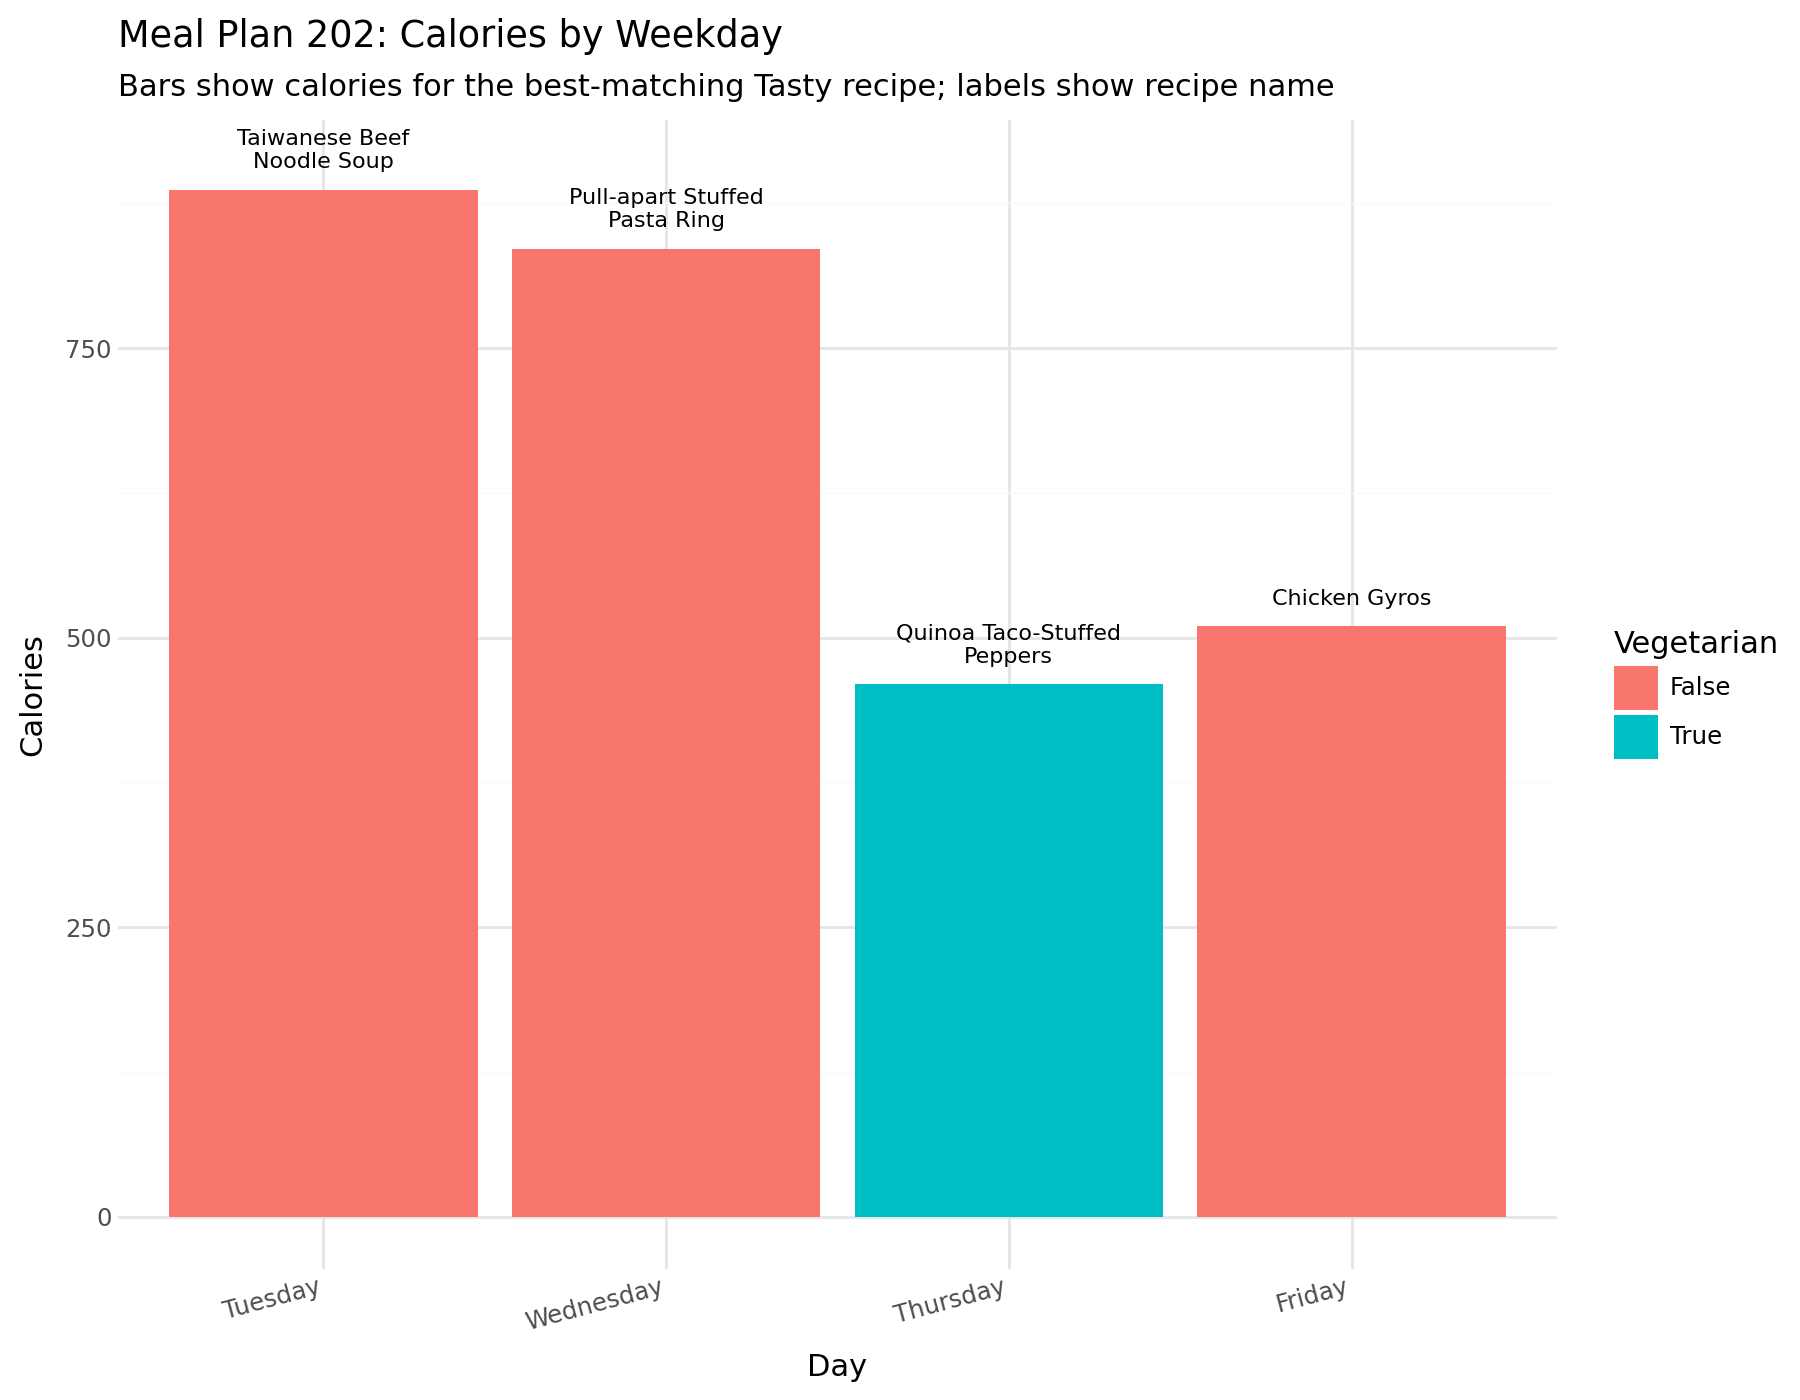

In [94]:
# --- Plot 1: Calories by weekday, indicating vegetarian ---
p = (
    p9.ggplot(best_per_day, p9.aes(x="Day of the Week", y="Calories", fill="Vegetarian"))
    + p9.geom_col()
    + p9.geom_text(p9.aes(label="WrapLabel"), va="bottom", size=8, format_string="{:s}", nudge_y=15)
    + p9.labs(
        title="Meal Plan 202: Calories by Weekday",
        subtitle="Bars show calories for the best-matching Tasty recipe; labels show recipe name",
        x="Day",
        y="Calories"
    )
    + p9.theme_minimal()
    + p9.theme(
        axis_text_x=p9.element_text(rotation=15, ha="right"),
        figure_size=(9, 7)
    )
)

p.show()

### Macro Computation
Convert macronutrients to numeric, derive calories from protein/carbs/fat, and reshape for plotting.

In [95]:
# compute macro calories
bp = best_per_day.copy()
for c in ["Protein","Fat","Carbs"]:
    bp[c] = pd.to_numeric(bp[c], errors="coerce")

bp["kcal_protein"] = bp["Protein"] * 4
bp["kcal_fat"]     = bp["Fat"] * 9
bp["kcal_carbs"]   = bp["Carbs"] * 4

bp["kcal_total_from_macros"] = bp[["kcal_protein","kcal_fat","kcal_carbs"]].sum(axis=1)

# percent-of-calories (guard divide-by-zero)
for c in ["kcal_protein","kcal_fat","kcal_carbs"]:
    bp[c + "_pct"] = (bp[c] / bp["kcal_total_from_macros"]) * 100

# gather to long for stacked bars
macro_long = (
    bp.melt(
        id_vars=["Day of the Week","Vegetarian","Tasty Recipe Name"],
        value_vars=["kcal_protein_pct","kcal_fat_pct","kcal_carbs_pct"],
        var_name="Macro", value_name="Percent"
    )
)
macro_long["Macro"] = macro_long["Macro"].map({
    "kcal_protein_pct":"Protein",
    "kcal_fat_pct":"Fat",
    "kcal_carbs_pct":"Carbs"
})

print(macro_long.head())

  Day of the Week  Vegetarian              Tasty Recipe Name    Macro    Percent
0         Tuesday       False     Taiwanese Beef Noodle Soup  Protein  30.459127
1       Wednesday       False  Pull-apart Stuffed Pasta Ring  Protein  20.168067
2        Thursday        True    Quinoa Taco-Stuffed Peppers  Protein  19.126819
3          Friday       False                  Chicken Gyros  Protein  33.925049
4         Tuesday       False     Taiwanese Beef Noodle Soup      Fat  33.258679


### Macronutrient Breakdown
Stacked bar chart of calories by macro across weekdays.

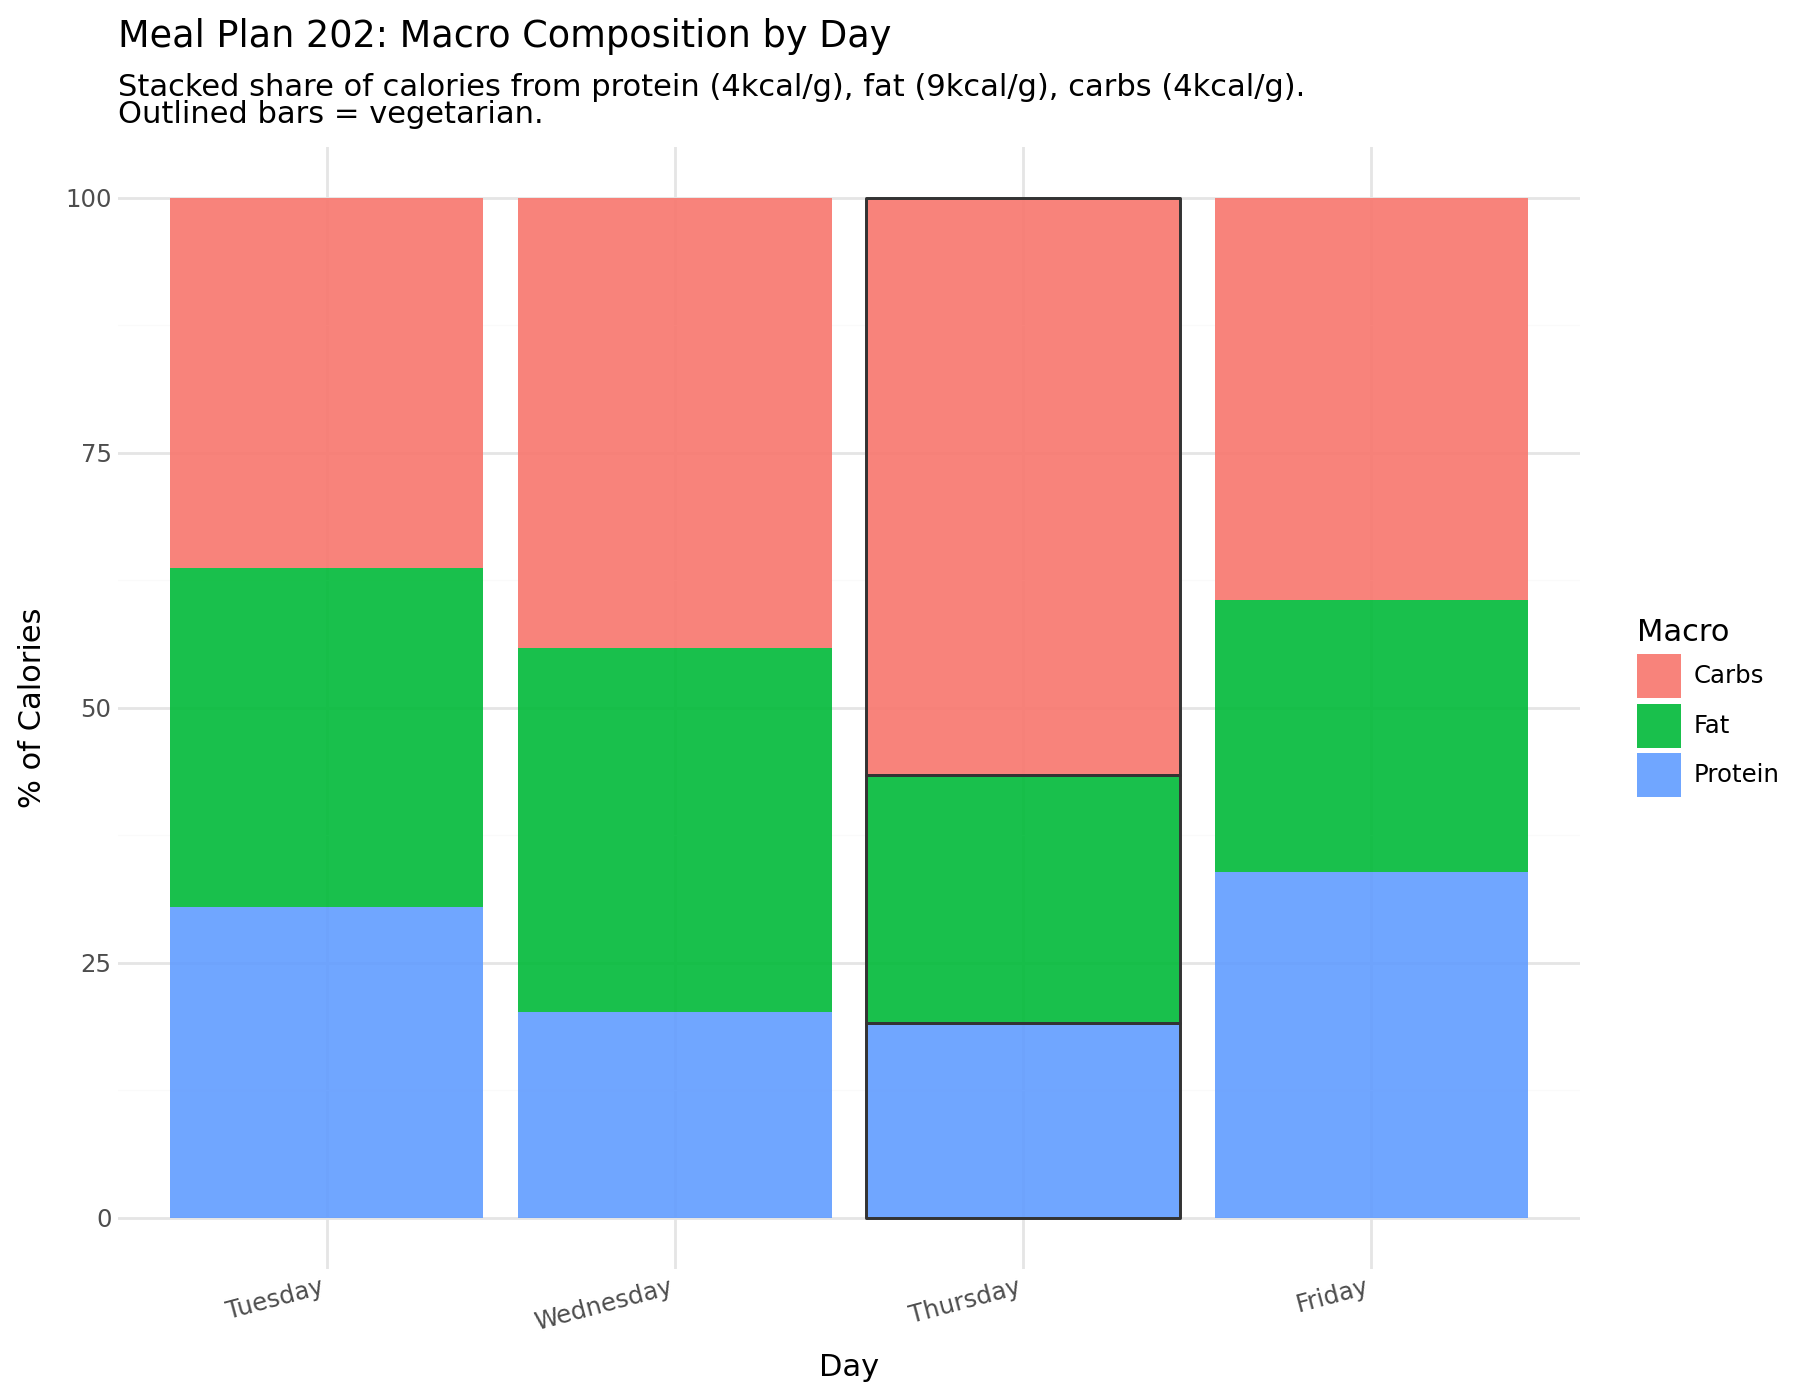

In [96]:
p2 = (
    p9.ggplot(macro_long, p9.aes(x="Day of the Week", y="Percent", fill="Macro"))
    + p9.geom_col(position="stack", alpha=0.9)
    # outline vegetarian days with a thin border:
    + p9.geom_col(data=macro_long[macro_long["Vegetarian"]==True],
                  fill=None, color="#333333", size=0.6)
    + p9.labs(
        title="Meal Plan 202: Macro Composition by Day",
        subtitle="Stacked share of calories from protein (4kcal/g), fat (9kcal/g), carbs (4kcal/g).\nOutlined bars = vegetarian.",
        x="Day", y="% of Calories"
    )
    + p9.scale_y_continuous(limits=[0,100])
    + p9.theme_minimal()
    + p9.theme(axis_text_x=p9.element_text(rotation=15, ha="right"), figure_size=(9,7))
)
p2.show()
